# Install and Import Libraries

In [1]:
# !pip install protobuf==3.19.6 # Install a specific version of the 'protobuf' package
# !pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0 # Install TensorFlow and TensorFlow Datasets with specific versions
# !pip install --upgrade tfds-nightly # Install the latest version of TensorFlow Datasets Nightly
# !pip show protobuf tensorflow tfds-nightly # Display information about the installed versions

In [2]:
# Importing necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import sys
import os
import re
import pickle
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow_datasets as tfds

# Set a random seed for reproducibility in TensorFlow
tf.keras.utils.set_random_seed(1234)

# Print the TensorFlow version to the console
print(f"TensorFlow version {tf.__version__}")

TensorFlow version 2.14.0


#### Check if TPU cluster exists

In [3]:
try:
    # Attempt to resolve a TPU cluster
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

    # Print information about the TPU cluster if available
    print(f"Running on TPU {tpu.cluster_spec().as_dict()['worker']}")

except ValueError:
    # If TPU is not available, set tpu to None
    tpu = None

# Check if TPU is available
if tpu:
    # Connect to the TPU cluster and initialize the TPU system
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)

    # Create a TPU strategy
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # If TPU is not available, use the default strategy
    strategy = tf.distribute.get_strategy()

# Print the number of replicas in the distributed strategy
print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


# Data Preprocessing

## Define Hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [4]:
# Maximum sentence length for text preprocessing
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 100000

# Batch size for tf.data.Dataset
BATCH_SIZE = 64

# Buffer size for shuffling the dataset
BUFFER_SIZE = 20000

# Transformer model hyperparameters
NUM_LAYERS = 2  # Number of transformer layers
D_MODEL = 256   # Dimension of the model
NUM_HEADS = 8    # Number of attention heads
UNITS = 512      # Number of units in the feedforward network
DROPOUT = 0.1    # Dropout rate

# Number of training epochs
EPOCHS = 60

## Prepare Dataset

In [5]:
# Download and extract the Cornell Movie Dialogs Corpus
path_to_zip = tf.keras.utils.get_file(
    "cornell_movie_dialogs.zip",
    origin="http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip",
    extract=True,
)

# Define paths to the dataset and its components
path_to_dataset = os.path.join(os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

# Paths to specific files in the dataset
path_to_movie_lines = os.path.join(path_to_dataset, "movie_lines.txt")
path_to_movie_conversations = os.path.join(path_to_dataset, "movie_conversations.txt")

## Define Functions for Preprocessing

In [6]:
# Preprocess sentences to remove unwanted characters and symbols.

# Args:
# sentence (str): Input sentence to be preprocessed.

# Returns:
# sentence (str): The preprocessed sentence after converting to lowercase, adding spaces between words and punctuation,
# handling contractions, removing unwanted characters, and stripping leading/trailing whitespaces.

def preprocess_sentence(sentence):
    # Convert to lowercase and remove leading/trailing whitespaces
    sentence = sentence.lower().strip()

    # Add space between words and punctuation
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # Handle contractions
    contractions = {
        "i'm": "i am",
        "he's": "he is",
        "she's": "she is",
        "it's": "it is",
        "that's": "that is",
        "what's": "that is",
        "where's": "where is",
        "how's": "how is",
        "'ll": " will",
        "'ve": " have",
        "'re": " are",
        "'d": " would",
        "won't": "will not",
        "can't": "cannot",
        "n't": " not",
        "n'": "ng",
        "'bout": "about"
    }
    sentence = ' '.join([contractions.get(word, word) for word in sentence.split()])

    # Remove characters other than (a-z, A-Z, ".", "?", "!", ",")
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    # Remove leading/trailing whitespaces
    sentence = sentence.strip()

    return sentence

In [7]:
# Load conversations from movie lines and movie conversations files.

# Args:
# None

# Returns:
# Tuple of lists: (inputs, outputs)
# inputs (list): List of preprocessed input sentences.
# outputs (list): List of preprocessed output sentences.

def load_conversations():
    # Dictionary to store line id to text mapping
    id2line = {}

    # Read movie lines file and create id2line dictionary
    with open(path_to_movie_lines, errors="ignore") as file:
        lines = file.readlines()

    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")
        id2line[parts[0]] = parts[4]

    inputs, outputs = [], []

    # Read movie conversations file and process conversations
    with open(path_to_movie_conversations, "r") as file:
        lines = file.readlines()

    for line in lines:
        parts = line.replace("\n", "").split(" +++$+++ ")

        # Get conversation as a list of line IDs
        conversation = [line[1:-1] for line in parts[3][1:-1].split(", ")]

        # Iterate through conversation pairs
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

            # Check if the maximum number of samples is reached
            if len(inputs) >= MAX_SAMPLES:
                return inputs, outputs

    return inputs, outputs

In [8]:
# Tokenize and filter input and output sentences.

# Args:
# inputs (list): List of preprocessed input sentences.
# outputs (list): List of preprocessed output sentences.

# Returns:
# Tuple of NumPy arrays: (tokenized_inputs, tokenized_outputs)
# tokenized_inputs (numpy.ndarray): Padded and tokenized input sequences.
# tokenized_outputs (numpy.ndarray): Padded and tokenized output sequences.

def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # Tokenize sentences and add start/end tokens
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # Check if tokenized sentences are within the max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # Pad tokenized sentences to max length
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs

## Preprocess Data

In [9]:
# Load conversations
questions, answers = load_conversations()

# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

# Tokenize and filter questions and answers
questions, answers = tokenize_and_filter(questions, answers)

# Print vocabulary size and number of samples
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 8174
Number of samples: 87812


In [10]:
# Get the lengths of sentences in the given data.

# Parameters:
# - data (list): A list of sentences, where each sentence is a list of words.

# Returns:
# - list: A list of integers representing the lengths of sentences.

def get_sentence_lengths(data):
    lengths = []
    for sentence in data:
        length = 0
        for word in sentence:
            if word == 0:  # Assuming 0 represents padding
                break
            else:
                length += 1
        lengths.append(length)
    return lengths

Average question length = 13.4841
Average answer length = 13.6199


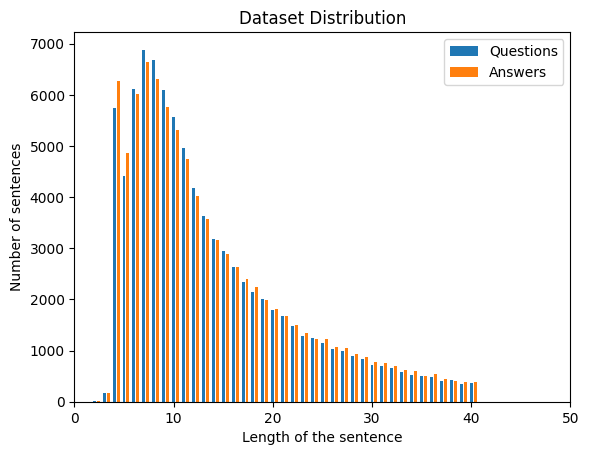

In [11]:
# Get sentence lengths for questions and answers
question_lengths = get_sentence_lengths(questions)
answer_lengths = get_sentence_lengths(answers)

# Create dictionaries to count occurrences of different sentence lengths
question_length_counts = {i: 0 for i in range(1, np.max(question_lengths) + 1)}
for length in question_lengths:
    question_length_counts[length] += 1

answer_length_counts = {i: 0 for i in range(1, 101)}
for length in answer_lengths:
    answer_length_counts[length] += 1

# Plot the distribution of sentence lengths
plt.bar([i for i in range(1, 101)], [question_length_counts.get(i, 0) for i in range(1, 101)], label='Questions', width=0.3)
plt.bar([i + 0.4 for i in range(1, 101)], [answer_length_counts.get(i, 0) for i in range(1, 101)], label='Answers', width=0.3)
plt.legend()
plt.xlabel('Length of the sentence')
plt.ylabel('Number of sentences')
plt.title('Dataset Distribution')

# Limit x-axis to 50
plt.xlim(0, 50)

plt.savefig('dataset.png', dpi=300)

# Print average lengths of questions and answers
print(f'Average question length = {np.mean(question_lengths):.4f}')
print(f'Average answer length = {np.mean(answer_lengths):.4f}')

In [12]:
# q_path = 'q.pickle'
# a_path = 'a.pickle'

# # Save tokenized questions to a pickle file
# # with open(q_path, 'wb') as file:
# #   pickle.dump(questions, file)

# # Save tokenized answers to a pickle file
# # with open(a_path, 'wb') as file:
# #   pickle.dump(answers, file)

# # Clear variables from memory
# questions = None
# answers = None

# # Load tokenized questions from the pickle file
# with open(q_path, 'rb') as file:
#     questions = pickle.load(file)

# # Load tokenized answers from the pickle file
# with open(a_path, 'rb') as file:
#     answers = pickle.load(file)

# # Print the number of samples after loading from pickle
# print(f"Number of samples: {len(questions)}")

In [13]:
# Decoder inputs use the previous target as input
# Remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": questions, "dec_inputs": answers[:, :-1]},
        {"outputs": answers[:, 1:]},
    )
)

# Cache the dataset for better performance
dataset = dataset.cache()

# Shuffle the dataset
dataset = dataset.shuffle(BUFFER_SIZE)

# Batch the dataset
dataset = dataset.batch(BATCH_SIZE)

# Prefetch the dataset for improved training speed
dataset = dataset.prefetch(tf.data.AUTOTUNE)

# Print the dataset information
print(dataset)

<_PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Attention



In [14]:
# Calculate the attention weights.

# Args:
# - query: Query tensor
# - key: Key tensor
# - value: Value tensor
# - mask: Mask tensor to zero out padding tokens

# Returns:
# - Output tensor after attention calculation

def scaled_dot_product_attention(query, key, value, mask):
    # Calculate the dot product of query and key
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Scale the dot product
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # Add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # Apply softmax to normalize on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # Calculate the weighted sum using attention weights
    output = tf.matmul(attention_weights, value)

    return output

In [15]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):

    # Initialize a Multi-Head Attention layer.
    # Args:
    # d_model (int): Dimensionality of the model.
    # num_heads (int): Number of attention heads.

    # Returns:
    # None
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0  # Ensure the model dimensions are divisible by the number of heads
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads  # Number of attention heads
        self.d_model = d_model  # Dimensionality of the model

        self.depth = d_model // self.num_heads  # Depth of each attention head

        # Linear layers for query, key, value
        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        # Final linear layer
        self.dense = tf.keras.layers.Dense(units=d_model)

    # Get the configuration of the Multi-Head Attention layer.
    # Args:
    # None

    # Returns:
    # config (dict): A dictionary containing the configuration parameters of the layer.
    def get_config(self):
        # Get the base configuration
        config = super(MultiHeadAttentionLayer, self).get_config()
        # Update with specific parameters of the Multi-Head Attention layer
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )

        return config


    # Split heads of the Multi-Head Attention layer.
    # Args:
    # inputs (tensor): Input tensor to be split.
    # batch_size (int): Batch size.

    # Returns:
    # tensor: Tensor after splitting heads.
    def split_heads(self, inputs, batch_size):
        # Reshape and transpose to split heads
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)

        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)


    # Perform the forward pass of the Multi-Head Attention layer.
    # Args:
    # inputs (dict): Dictionary containing 'query', 'key', 'value', and 'mask' tensors.

    # Returns:
    # outputs (tensor): Output tensor after the forward pass of the Multi-Head Attention layer.
    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # Linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # Concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # Final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer

### Masking



In [16]:
# Create a padding mask for input sequences.

# Args:
# x (tensor): Input tensor.

# Returns:
# tensor: Padding mask with extra dimensions.

def create_padding_mask(x):
    # Create a mask where x is equal to 0
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)

    # Add extra dimensions to the mask
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [17]:
# Create a look-ahead mask for input sequences.

# Args:
# x (tensor): Input tensor.

# Returns:
# tensor: Look-ahead mask combined with a padding mask.

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]

    # Create a triangular mask with zeros on and below the main diagonal
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

    # Create a padding mask
    padding_mask = create_padding_mask(x)

    # Combine the look-ahead mask with the padding mask using element-wise maximum
    return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [18]:
# Positional Encoding layer for transformer models.
class PositionalEncoding(tf.keras.layers.Layer):
    # Initialize the Positional Encoding layer for transformer models.
    # Args:
    # position (int): Maximum position value for encoding.
    # d_model (int): Dimensionality of the model.
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    # Get the configuration of the Positional Encoding layer.
    # Returns:
    # dict: A dictionary containing the configuration parameters of the layer.
    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    # Get angles for the positional encoding.
    # Args:
    # position (tensor): Position values for encoding.
    # i (tensor): Indices for calculating angles.
    # d_model (int): Dimensionality of the model.

    # Returns:
    # tensor: Angles used in the positional encoding.
    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    # Calculate the positional encoding matrix.
    # Args:
    # position (int): Maximum position value for encoding.
    # d_model (int): Dimensionality of the model.

    # Returns:
    # tensor: Positional encoding matrix.
    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # Apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    # Perform the forward pass of the Positional Encoding layer.
    # Args:
    # inputs (tensor): Input tensor to be processed.

    # Returns:
    # tensor: Output tensor after adding positional encoding.
    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

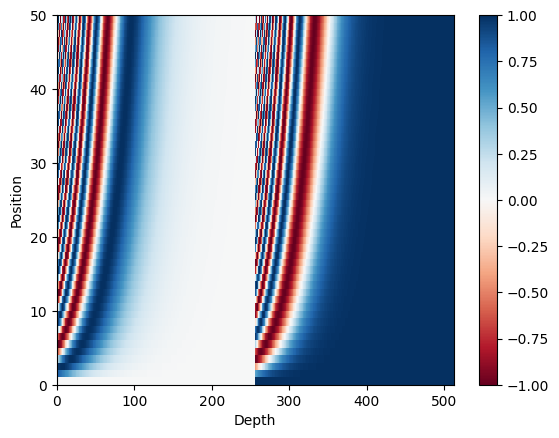

In [19]:
sample_pos_encoding = PositionalEncoding(50, 512, name="sample_pos_encoding")

# Visualize the positional encoding
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap="RdBu")
plt.xlabel("Depth")
plt.xlim((0, 512))
plt.ylabel("Position")
plt.colorbar()
plt.show()

In [20]:
# Create an encoder layer for a transformer model.

# Args:
# units (int): Number of units in the feedforward part of the layer.
# d_model (int): Dimensionality of the model.
# num_heads (int): Number of attention heads in the multi-head attention layer.
# dropout (float): Dropout rate.
# name (str): Name of the layer.

# Returns:
# tf.keras.Model: Encoder layer model.

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Multi-head self-attention
    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)

    # Skip connection and layer normalization
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    # Feedforward part
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

    # Skip connection and layer normalization
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [21]:
# Create an encoder for a transformer model.

# Args:
# vocab_size (int): Size of the vocabulary.
# num_layers (int): Number of encoder layers.
# units (int): Number of units in the feedforward part of each layer.
# d_model (int): Dimensionality of the model.
# num_heads (int): Number of attention heads in the multi-head attention layer.
# dropout (float): Dropout rate.
# name (str): Name of the encoder.

# Returns:
# tf.keras.Model: Encoder model.

def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Embedding layer with positional encoding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # Stack multiple encoder layers
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [22]:
# Create a decoder layer for a transformer model.

# Args:
# units (int): Number of units in the feedforward part of the layer.
# d_model (int): Dimensionality of the model.
# num_heads (int): Number of attention heads in the multi-head attention layers.
# dropout (float): Dropout rate.
# name (str): Name of the layer.

# Returns:
# tf.keras.Model: Decoder layer model.

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Masked multi-head self-attention
    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    # Multi-head attention over encoder outputs
    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    # Feedforward part
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

    # Skip connection and layer normalization
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [23]:
# Create a decoder for a transformer model.

# Args:
# vocab_size (int): Size of the vocabulary.
# num_layers (int): Number of decoder layers.
# units (int): Number of units in the feedforward part of each layer.
# d_model (int): Dimensionality of the model.
# num_heads (int): Number of attention heads in the multi-head attention layers.
# dropout (float): Dropout rate.
# name (str): Name of the decoder.

# Returns:
# tf.keras.Model: Decoder model.

def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # Embedding layer with positional encoding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # Stack multiple decoder layers
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )


### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [24]:
# Create a transformer model.

# Args:
# vocab_size (int): Size of the vocabulary.
# num_layers (int): Number of encoder and decoder layers.
# units (int): Number of units in the feedforward part of each layer.
# d_model (int): Dimensionality of the model.
# num_heads (int): Number of attention heads in the multi-head attention layers.
# dropout (float): Dropout rate.
# name (str): Name of the transformer model.

# Returns:
# tf.keras.Model: Transformer model.

def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # Mask for encoder inputs
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)

    # Mask for future tokens in decoder inputs
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)

    # Mask for encoder outputs in decoder inputs
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    # Encoder
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # Decoder
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # Output layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Train model

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [25]:
# Calculate the loss for the transformer model.

# Args:
# y_true (tensor): True labels.
# y_pred (tensor): Predicted labels.

# Returns:
# float: Mean loss.

def loss_function(y_true, y_pred):
    # Reshape y_true to match the model's output shape
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # Sparse categorical cross-entropy loss with mask
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    # Mask for non-padded positions
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    # Compute mean of the loss
    return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
#     Custom learning rate schedule.

#     Args:
#     - d_model (int): Dimensionality of the model.
#     - warmup_steps (int): Number of warmup steps during training.

#     Returns:
#     - None
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)  # Ensure d_model is of float32 type
        self.warmup_steps = warmup_steps

#     Get the configuration of the learning rate schedule.

#     Args:
#     - None

#     Returns:
#     - dict: A dictionary containing the configuration parameters.
    def get_config(self):
        return {"d_model": self.d_model.numpy(), "warmup_steps": self.warmup_steps}



#     Compute the learning rate for a given step.

#     Args:
#     - step (tf.Tensor): Current training step.

#     Returns:
#     - tf.Tensor: Computed learning rate.
    def __call__(self, step):
        arg1 = tf.math.rsqrt(tf.cast(step, tf.float32))
        arg2 = tf.cast(step, tf.float32) * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

## Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [27]:
# Compute accuracy between true and predicted sequences.

# Args:
# - y_true (tf.Tensor): True labels.
# - y_pred (tf.Tensor): Predicted probabilities.

# Returns:
# - tf.Tensor: Computed accuracy.

def accuracy(y_true, y_pred):
    # Ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    # Use sparse categorical accuracy
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [28]:
# Clear backend
tf.keras.backend.clear_session()

# Create a custom learning rate schedule
learning_rate = CustomSchedule(D_MODEL)

# Create an Adam optimizer with custom learning rate
optimizer_adam = tf.keras.optimizers.legacy.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9
)

# Create an RMSprop optimizer with custom parameters
optimizer_rmsprop = tf.keras.optimizers.RMSprop(
    learning_rate=learning_rate, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False
)

# Initialize and compile the model within the strategy scope
with strategy.scope():
    # Create the transformer model
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    # Compile the model with the custom optimizer, loss function, and accuracy metric
    model.compile(optimizer=optimizer_rmsprop, loss=loss_function, metrics=[accuracy])

# Display the model summary
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputs (InputLayer)         [(None, None)]               0         []                            
                                                                                                  
 dec_inputs (InputLayer)     [(None, None)]               0         []                            
                                                                                                  
 enc_padding_mask (Lambda)   (None, 1, 1, None)           0         ['inputs[0][0]']              
                                                                                                  
 encoder (Functional)        (None, None, 256)            3146752   ['inputs[0][0]',              
                                                                     'enc_padding_mask[0

### Fit model

Train our transformer by simply calling `model.fit()`

In [29]:
# Record the start time
start_time = time.time()

# Train the model using the provided dataset for a specified number of epochs
history = model.fit(dataset, epochs=EPOCHS)

# Record the end time
end_time = time.time()

# Print the total time taken for training
print(f'Time Taken: {end_time - start_time:.4f}')

Epoch 1/60
1373/1373 [==============================] - 117s 71ms/step - loss: 1.9738 - accuracy: 0.0496
Epoch 2/60
1373/1373 [==============================] - 81s 59ms/step - loss: 1.4776 - accuracy: 0.0817
Epoch 3/60
1373/1373 [==============================] - 81s 59ms/step - loss: 1.3888 - accuracy: 0.0875
Epoch 4/60
1373/1373 [==============================] - 81s 59ms/step - loss: 1.3293 - accuracy: 0.0919
Epoch 5/60
1373/1373 [==============================] - 80s 58ms/step - loss: 1.2779 - accuracy: 0.0959
Epoch 6/60
1373/1373 [==============================] - 80s 58ms/step - loss: 1.2382 - accuracy: 0.0988
Epoch 7/60
1373/1373 [==============================] - 79s 58ms/step - loss: 1.2060 - accuracy: 0.1013
Epoch 8/60
1373/1373 [==============================] - 80s 58ms/step - loss: 1.1789 - accuracy: 0.1034
Epoch 9/60
1373/1373 [==============================] - 80s 58ms/step - loss: 1.1547 - accuracy: 0.1054
Epoch 10/60
1373/1373 [==============================] - 79s 57

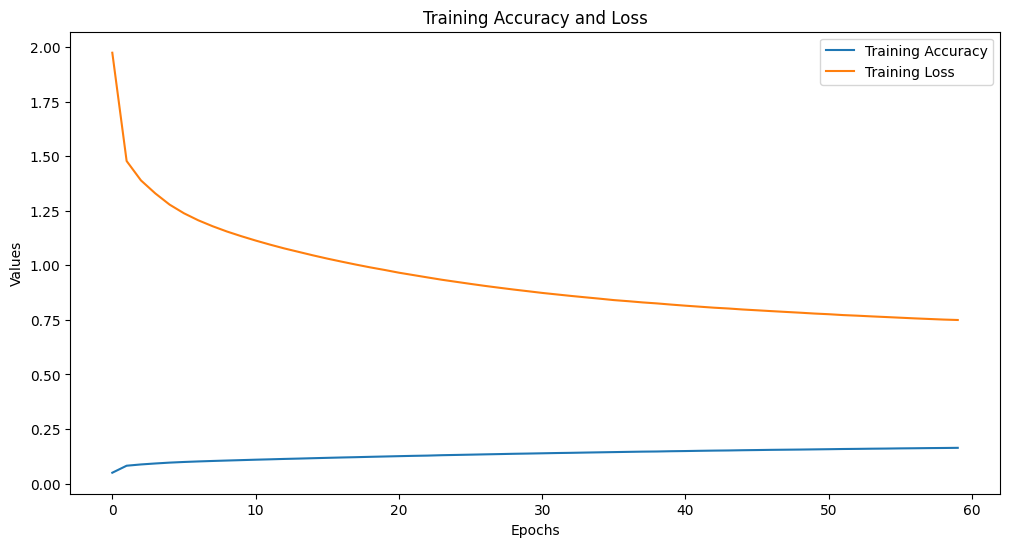

In [30]:
# Plot Accuracy and Loss graphs
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')

# Plot training loss values
plt.plot(history.history['loss'], label='Training Loss')

# Set labels and title
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.title('Training Accuracy and Loss')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Save and load model

In [31]:
# filename = "model.h5"
# tf.keras.models.save_model(model, filepath=filename, include_optimizer=False)

In [32]:
# del model
# tf.keras.backend.clear_session()

In [33]:
# model = tf.keras.models.load_model(
#     'model.h5',
#     custom_objects={
#         "PositionalEncoding": PositionalEncoding,
#         "MultiHeadAttentionLayer": MultiHeadAttentionLayer,
#     },
#     compile=False,
# )

In [34]:
# model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`.
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [35]:
# Evaluate a given sentence using the trained transformer model.

# Args:
# - sentence (str): Input sentence to be evaluated.

# Returns:
# - tf.Tensor: Predicted output sequence.

def evaluate(sentence):
    # Preprocess the input sentence
    sentence = preprocess_sentence(sentence)

    # Add start and end tokens, and expand dimensions for model input
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # Initialize output tensor with start token
    output = tf.expand_dims(START_TOKEN, 0)

    # Iterate through the maximum allowed length
    for i in range(MAX_LENGTH):
        # Get model predictions
        predictions = model(inputs=[sentence, output], training=False)

        # Select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # Concatenate the predicted_id to the output for the next iteration
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)

In [36]:
# Generate a prediction for a given input sentence using the trained transformer model.

# Args:
# - sentence (str): Input sentence for prediction.

# Returns:
# - str: Predicted output sentence.

def predict(sentence):
    # Get the predicted sequence using the evaluate function
    prediction = evaluate(sentence)

    # Decode the predicted sequence using the tokenizer
    predicted_sentence = tokenizer.decode([i for i in prediction if i < tokenizer.vocab_size])

    return predicted_sentence

## Testing our model

In [37]:
predict("Where have you been?")

'i was thinking of the same thing . i was going to see if i had to get a job , i didn t see it . i was gonna be here last night .'

In [38]:
predict("It's a trap")

'there s no way to where he is . where is the car ?'

In [39]:
# feed the model with its previous output
sentence = "I am not crazy, my mother had me tested."
for _ in range(5):
    print(f"Input: {sentence}")
    sentence = predict(sentence)
    print(f"Output: {sentence}\n")

Input: I am not crazy, my mother had me tested.
Output: and you never asked me for that , not a time ?

Input: and you never asked me for that , not a time ?
Output: i am not sure i wouldn t want to be here at all .

Input: i am not sure i wouldn t want to be here at all .
Output: and you were right at the time you were at your house . i was trying to get my job .

Input: and you were right at the time you were at your house . i was trying to get my job .
Output: what do you mean ?

Input: what do you mean ?
Output: i don t know . i am not sure i could be able to get into the car but i never knew that i was here .

